In [1]:
import os
import glob
import pandas as pd
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns
from scipy import stats
import warnings 
from matplotlib.colors import NoNorm
warnings.filterwarnings('ignore')
mpl.rcParams['font.size'] = 9

In [2]:
# reading all files
filenames = glob.glob(os.path.join('datasets', "*.csv"))
cycles = pd.concat((pd.read_csv(file) for file in filenames), ignore_index=True)

# data wrangling
cycles.dropna(axis = 0, how = 'any', inplace=True)
cycles.reset_index(drop=True, inplace=True)

cycles['started_at'] = pd.to_datetime(cycles.started_at, format="%Y-%m-%d %H:%M:%S")
cycles['ended_at'] = pd.to_datetime(cycles.ended_at)

cycles['start_hour'] = pd.to_numeric(cycles['started_at'].apply(lambda x: x.strftime('%H')))
#cycles['start_12_hour_format'] = cycles['started_at'].apply(lambda x: x.strftime('%I%p'))

cycles['start_station_latitude'] = np.radians(cycles['start_station_latitude'])
cycles['end_station_latitude'] = np.radians(cycles['end_station_latitude'])
cycles['start_station_longitude'] = np.radians(cycles['start_station_longitude'])
cycles['end_station_longitude'] = np.radians(cycles['end_station_longitude'])

diff_longitude = cycles['end_station_longitude'] - cycles['start_station_longitude']
diff_latitude = cycles['end_station_latitude'] - cycles['start_station_latitude']

R = 6373.0
a = np.sin(diff_latitude/2)**2 + np.cos(cycles['start_station_latitude']) * np.cos(cycles['end_station_latitude']) * np.sin(diff_longitude/2)**2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
displacement = R * c
cycles['displacement'] = displacement

cycles_pre_lockdown = cycles[cycles['started_at'] < '2020-03-23'].reset_index(drop = True)
cycles_post_lockdown = cycles[cycles['started_at'] >= '2020-03-23'].reset_index(drop = True)
cycles_post_1st_lockdown = cycles[('2020-03-23' <= cycles['started_at']) & (cycles['started_at'] < '2020-09-22')].reset_index(drop = True)
cycles_post_2nd_lockdown = cycles['2020-09-22' <= cycles['started_at']].reset_index(drop = True)

cycles_2018 = cycles[cycles['started_at'] < '2019-01-01'].reset_index(drop = True)
cycles_2019 = cycles[('2018-12-30' < cycles['started_at']) & (cycles['started_at'] < '2020-01-01')].reset_index(drop = True)
cycles_2020 = cycles[('2019-12-30' < cycles['started_at']) & (cycles['started_at'] < '2021-01-01')].reset_index(drop = True)
cycles_2021 = cycles['2020-12-30' < cycles['started_at']].reset_index(drop = True)

cycles_2019_summers = cycles[('2019-06-21' <= cycles['started_at']) & (cycles['started_at'] <= '2019-09-23')].reset_index(drop = True)
cycles_2020_summers = cycles[('2020-06-20' <= cycles['started_at']) & (cycles['started_at'] <= '2020-09-22')].reset_index(drop = True)

cycles_2019_winters = cycles[('2019-12-22' <= cycles['started_at']) & (cycles['started_at'] <= '2020-03-20')].reset_index(drop = True)
cycles_2020_winters = cycles[('2020-12-21' <= cycles['started_at']) & (cycles['started_at'] <= '2021-03-20')].reset_index(drop = True)

In [3]:
displacement_count_2018 = cycles_2018.groupby('displacement').size().reset_index(name = 'count').sort_values(['count'], ascending = False, ignore_index = True)
displacement_count_2019 = cycles_2019.groupby('displacement').size().reset_index(name = 'count').sort_values(['count'], ascending = False, ignore_index = True)
displacement_count_2020 = cycles_2020.groupby('displacement').size().reset_index(name = 'count').sort_values(['count'], ascending = False, ignore_index = True)
displacement_count_2021 = cycles_2021.groupby('displacement').size().reset_index(name = 'count').sort_values(['count'], ascending = False, ignore_index = True)

displacement_count_pre_lockdown = cycles_pre_lockdown.groupby('displacement').size().reset_index(name = 'count').sort_values(['count'], ascending = False, ignore_index = True)
displacement_count_post_1st_lockdown = cycles_post_1st_lockdown.groupby('displacement').size().reset_index(name = 'count').sort_values(['count'], ascending = False, ignore_index = True)
displacement_count_post_2nd_lockdown = cycles_post_2nd_lockdown.groupby('displacement').size().reset_index(name = 'count').sort_values(['count'], ascending = False, ignore_index = True)

displacement_count_2019_summers = cycles_2019_summers.groupby('displacement').size().reset_index(name = 'count').sort_values(['count'], ascending = False, ignore_index = True)
displacement_count_2020_summers = cycles_2020_summers.groupby('displacement').size().reset_index(name = 'count').sort_values(['count'], ascending = False, ignore_index = True)

displacement_count_2019_winters = cycles_2019_winters.groupby('displacement').size().reset_index(name = 'count').sort_values(['count'], ascending = False, ignore_index = True)
displacement_count_2020_winters = cycles_2020_winters.groupby('displacement').size().reset_index(name = 'count').sort_values(['count'], ascending = False, ignore_index = True)

Hypothesis testing for pre_lockdown and post_lockdown months. We perfomed a 2-sample t-test where the vairance is unknown. Null hypothesis: lockdown has no effect on the average duration of bike rides. Alternative hypothesis: lockdown had an effect on the average duration of bike rides.

In [4]:
stats.ttest_ind(cycles_pre_lockdown['duration'], cycles_post_lockdown['duration'], equal_var = False)

Ttest_indResult(statistic=-15.10014842290259, pvalue=1.7429955960190103e-51)

We can see that the p-value is significantly smaller and hence, we can conclude that there is enough evidence to reject the null hypothesis, i.e., lockdown has no effect on the average duration of bike rides, in favour of the alternative hypothesis.

In [5]:
cycles_months = cycles.groupby(pd.Grouper(key='started_at',freq='M')).size()

cycles_hourly = cycles.groupby('start_hour').size()
cycles_2018_hourly = cycles_2018.groupby('start_hour').size()
cycles_2019_hourly = cycles_2019.groupby('start_hour').size()
cycles_2020_hourly = cycles_2020.groupby('start_hour').size()
cycles_2021_hourly = cycles_2021.groupby('start_hour').size()

cycles_pre_lockdown_hourly = cycles_pre_lockdown.groupby('start_hour').size()
cycles_post_lockdown_hourly = cycles_post_lockdown.groupby('start_hour').size()
cycles_post_1st_lockdown_hourly = cycles_post_1st_lockdown.groupby('start_hour').size()
cycles_post_2nd_lockdown_hourly = cycles_post_2nd_lockdown.groupby('start_hour').size()

cycles_2019_summers_hourly = cycles_2019_summers.groupby('start_hour').size()
cycles_2020_summers_hourly = cycles_2020_summers.groupby('start_hour').size()
cycles_2019_winters_hourly = cycles_2019_winters.groupby('start_hour').size()
cycles_2020_winters_hourly = cycles_2020_winters.groupby('start_hour').size()

cycles_pre_lockdown_hourly = cycles_pre_lockdown_hourly[4:].tolist() + cycles_pre_lockdown_hourly[0:4].tolist()
cycles_post_lockdown_hourly = cycles_post_lockdown_hourly[4:].tolist() + cycles_post_lockdown_hourly[0:4].tolist()
cycles_post_1st_lockdown_hourly = cycles_post_1st_lockdown_hourly[4:].tolist() + cycles_post_1st_lockdown_hourly[0:4].tolist()
cycles_post_2nd_lockdown_hourly = cycles_post_2nd_lockdown_hourly[4:].tolist() + cycles_post_2nd_lockdown_hourly[0:4].tolist()

cycles_2019_summers_hourly = cycles_2019_summers_hourly[4:].tolist() + cycles_2019_summers_hourly[0:4].tolist()
cycles_2020_summers_hourly = cycles_2020_summers_hourly[4:].tolist() + cycles_2020_summers_hourly[0:4].tolist()
cycles_2019_winters_hourly = cycles_2019_winters_hourly[4:].tolist() + cycles_2019_winters_hourly[0:4].tolist()
cycles_2020_winters_hourly = cycles_2020_winters_hourly[4:].tolist() + cycles_2020_winters_hourly[0:4].tolist()

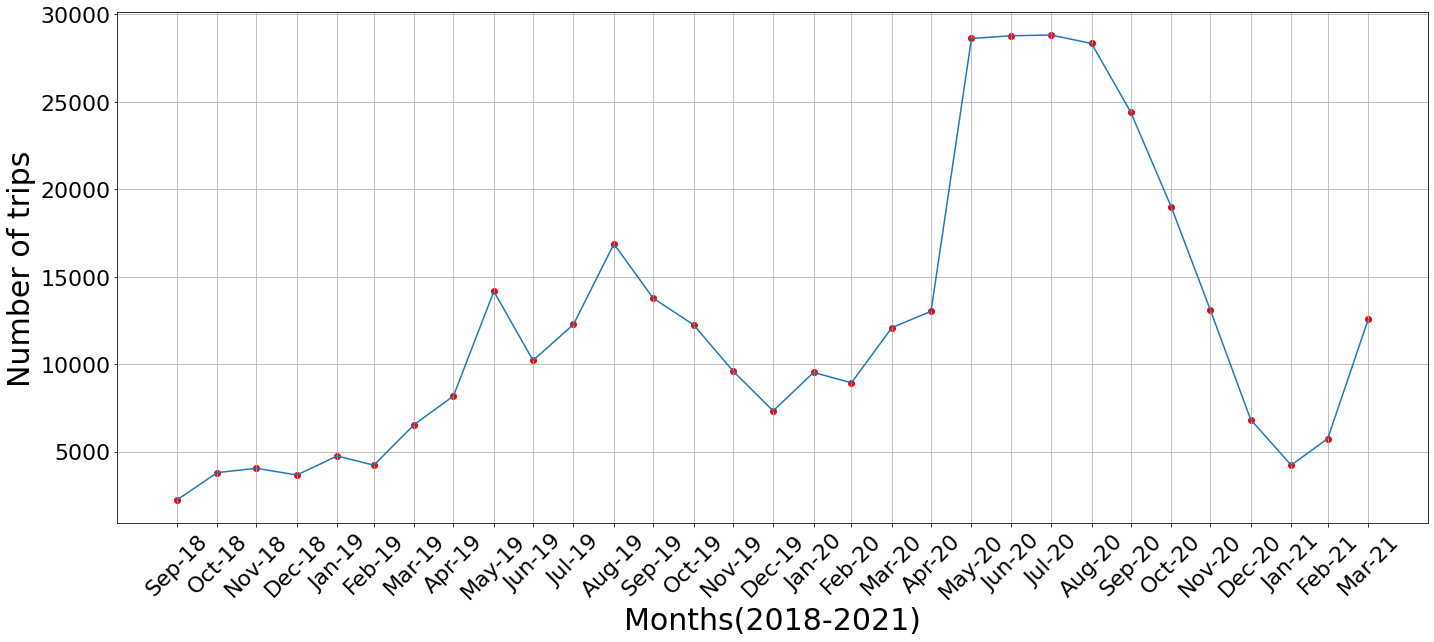

In [6]:
# plot for number of trips per month
date_form = DateFormatter("%b-%y")
plt.figure(figsize=(20,9))
plt.plot(cycles_months.index.values,cycles_months)
plt.scatter(cycles_months.index.values,cycles_months,c='red')
plt.xticks(cycles_months.index.values,rotation=45)
plt.tick_params('both', labelsize = 22)
plt.xlabel('Months(2018-2021)',fontsize=30)
plt.ylabel('Number of trips',fontsize=30)
#plt.title('Number of Trips per month',fontsize=25)
plt.gca().xaxis.set_major_formatter(date_form) 
plt.grid(True)
plt.tight_layout()
plt.savefig('datasets/total_trips_per_month.pdf')
plt.show()

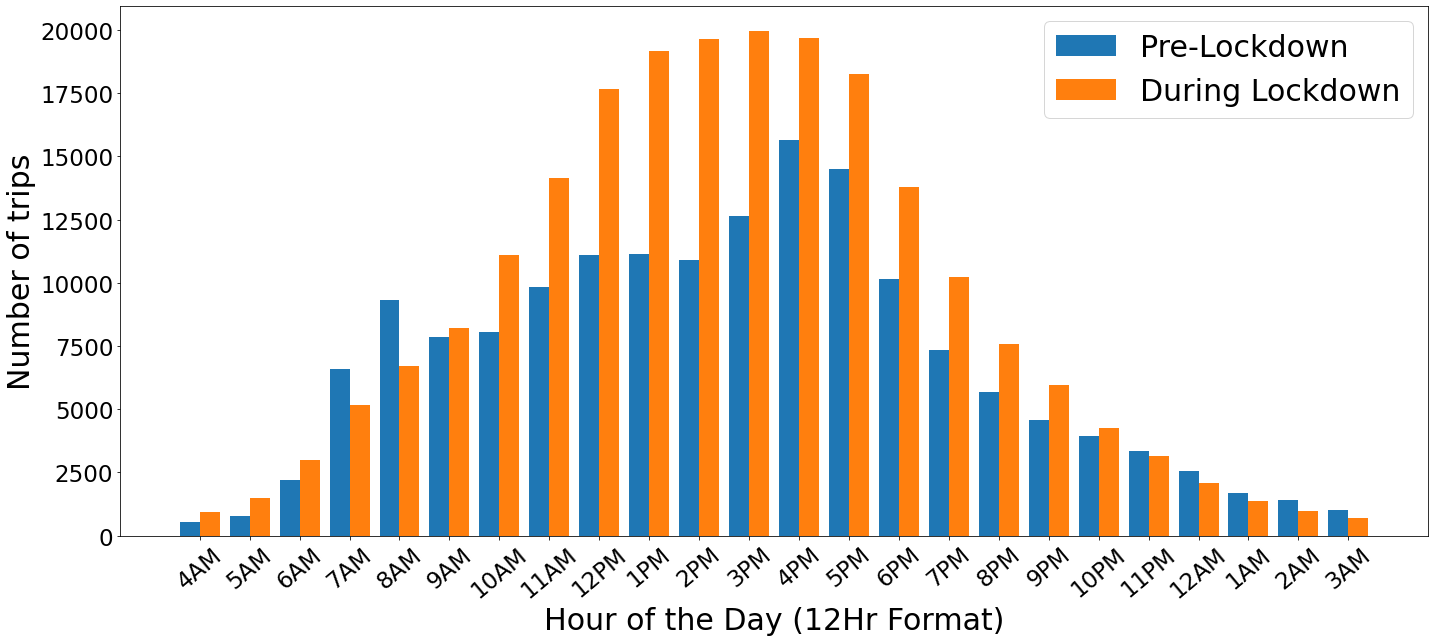

In [7]:
# plot for number of trips grouped by hour before and after 1st lockdown
fig, ax1 = plt.subplots(figsize = (20,9))
ax1.bar(np.arange(0,24) - 0.2,cycles_pre_lockdown_hourly, width = 0.4)
ax1.bar(np.arange(0,24) + 0.2,cycles_post_lockdown_hourly, width = 0.4)
ax1.legend(['Pre-Lockdown', 'During Lockdown'], fontsize = 30)
ax1.set_ylim(0)
labels = ['4AM','5AM','6AM','7AM','8AM','9AM','10AM','11AM','12PM','1PM','2PM','3PM','4PM','5PM','6PM','7PM','8PM','9PM','10PM','11PM','12AM','1AM','2AM','3AM']
plt.xticks(np.arange(0,24), labels=labels, rotation = 40)
plt.tick_params('both', labelsize = 23)
plt.xlabel('Hour of the Day (12Hr Format)',fontsize=30)
plt.ylabel('Number of trips',fontsize=30)
#plt.title('Number of Bike Trips by hour',fontsize=25)
plt.tight_layout()
plt.savefig('datasets/total_trips_by_hour_pre_post_lockdown.pdf')

In [8]:
colors = ["red","green","blue","black","orange","purple","brown","gray","indigo","deeppink"]

In [9]:
cycles_pre_freq = cycles_pre_lockdown.groupby(pd.Grouper(key='start_station_name')).size().sort_values(ascending=False)
cycles_pre_unique = cycles_pre_lockdown.drop_duplicates(subset=['start_station_name'])
latitude_pre = []
longitude_pre = []
for i in range(10):
    y = cycles_pre_unique[cycles_pre_unique['start_station_name'] == cycles_pre_freq.index[i]]
    latitude_pre.append(y['start_station_latitude'])
    longitude_pre.append(y['start_station_longitude'])
station_name_pre = []
for i in range(10):
    station_name_pre.append(cycles_pre_freq.index[i])

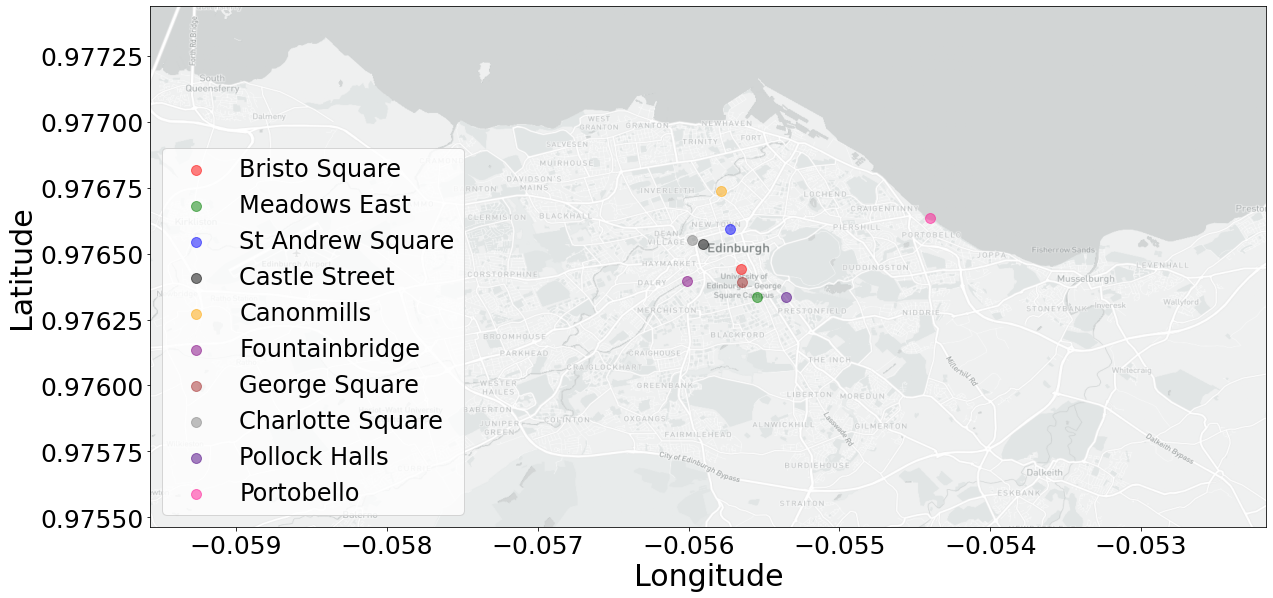

In [10]:
edi_img1 = mpimg.imread('datasets\edi_map_bw.png')
plt.figure(figsize=(20,10))
edi_plot = plt.imshow(edi_img1,extent=np.radians([-3.413,-2.989,55.89,56.003]),aspect=1.75)
for i in range(10):
    x = longitude_pre[i]
    y = latitude_pre[i]
    plt.scatter(x, y, marker='o', color=colors[i],s=100,alpha=0.5)
plt.tick_params(axis = 'both', which = 'major', labelsize = 25)
plt.legend(station_name_pre,fontsize = 24,loc="lower left")
plt.xlabel('Longitude',fontsize=30)
plt.ylabel('Latitude',fontsize=30)
plt.savefig('datasets/popular_stations_pre_lockdown.pdf')
plt.show()

In [11]:
cycles_post_freq = cycles_post_1st_lockdown.groupby(pd.Grouper(key='start_station_name')).size().sort_values(ascending=False)
cycles_post_unique = cycles_post_1st_lockdown.drop_duplicates(subset=['start_station_name'])
latitude_post = []
longitude_post = []
for i in range(10):
    y = cycles_post_unique[cycles_post_unique['start_station_name'] == cycles_post_freq.index[i]]
    latitude_post.append(y['start_station_latitude'])
    longitude_post.append(y['start_station_longitude'])
station_name_post = []
for i in range(10):
    station_name_post.append(cycles_post_freq.index[i])

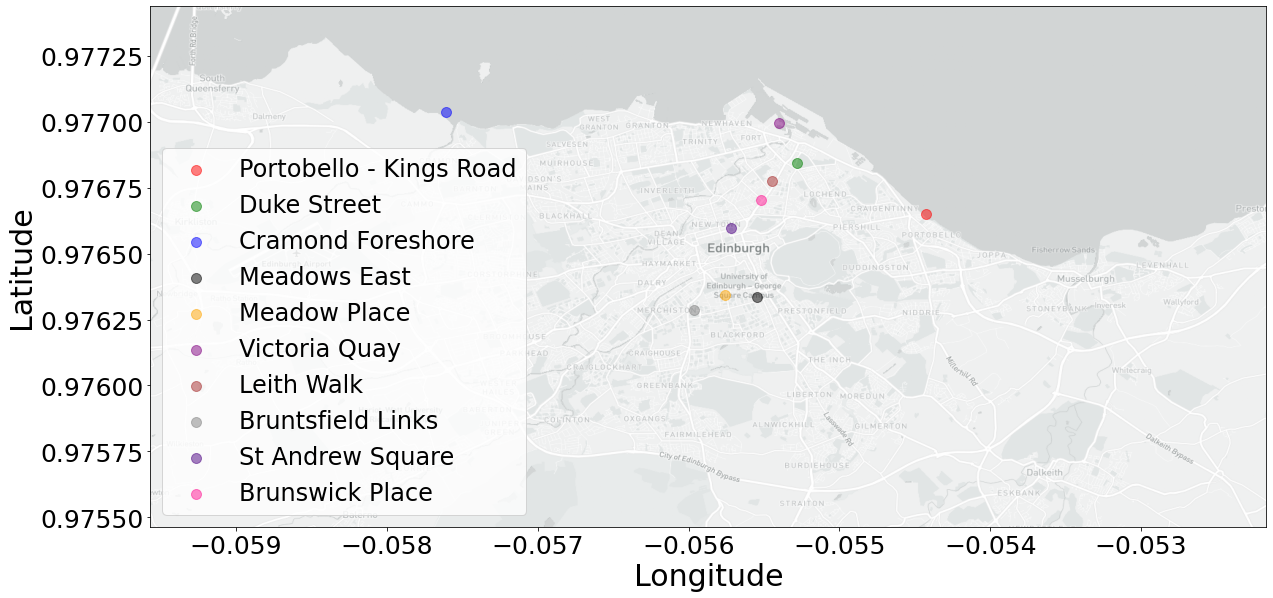

In [12]:
edi_img2 = mpimg.imread('datasets\edi_map_bw.png')
plt.figure(figsize=(20,10))
edi_plot = plt.imshow(edi_img2,extent=np.radians([-3.413,-2.989,55.89,56.003]),aspect=1.75)
for i in range(10):
    x = longitude_post[i]
    y = latitude_post[i]
    plt.scatter(x, y, marker='o', color=colors[i],s=100,alpha=0.5)
plt.tick_params(axis = 'both', which = 'major', labelsize = 25)
plt.xlabel('Longitude',fontsize=30)
plt.ylabel('Latitude',fontsize=30)
plt.legend(station_name_post,fontsize = 24,loc="lower left")
plt.savefig('datasets/popular_stations_post_1st_lockdown.pdf')
plt.show()

In [13]:
cycles_concat = pd.concat([cycles_pre_freq, cycles_post_freq], axis=1).reset_index()
cycles_unique = pd.concat([cycles_pre_lockdown,cycles_post_2nd_lockdown]).drop_duplicates(subset=['start_station_name'])
cycles_concat.rename(columns={"index": "station_name", 0: "pre", 1: "post"}, errors="raise",inplace=True)
cycles_concat.dropna(axis = 0,inplace=True)
cycles_concat['percentage_diff'] = ((cycles_concat['post'] - cycles_concat['pre'])/cycles_concat['pre']) * 100
cycles_concat.sort_values(by=['percentage_diff'],ascending=True, inplace=True)
cycles_concat.reset_index(drop=True,inplace=True)
percent_diff = cycles_concat['percentage_diff'].iloc[:10]
station_names = cycles_concat['station_name'].iloc[:10]
latitude_diff = []
longitude_diff = []
for i in range(10):
    y = cycles_unique[cycles_unique['start_station_name'] == cycles_concat['station_name'].iloc[i]]
    latitude_diff.append(y['start_station_latitude'])
    longitude_diff.append(y['start_station_longitude'])

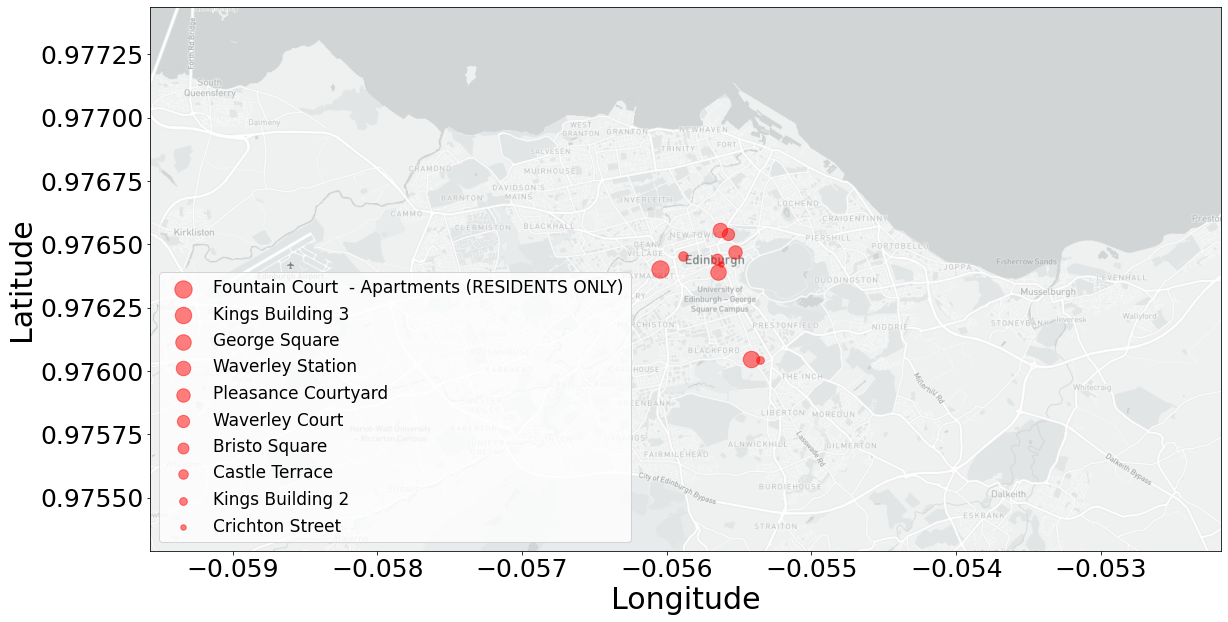

In [14]:
edi_img3 = mpimg.imread('datasets\edi_map_bw.png')
plt.figure(figsize=(20,10))
edi_plot = plt.imshow(edi_img3,extent=np.radians([-3.413,-2.989,55.88,56.003]),aspect=1.75)
size_point = 300
for i in range(10):
    x = longitude_diff[i]
    y = latitude_diff[i]
    plt.scatter(x, y, marker='o', color='red',s=size_point,alpha=0.5)
    size_point -= 30
plt.tick_params(axis = 'both', which = 'major', labelsize = 25)
legend1 = plt.legend(station_names,fontsize = 17,loc="lower left")
plt.xlabel('Longitude',fontsize=30)
plt.ylabel('Latitude',fontsize=30)
plt.savefig('datasets/stations_most_trips_percentage_drop.pdf')
plt.show()

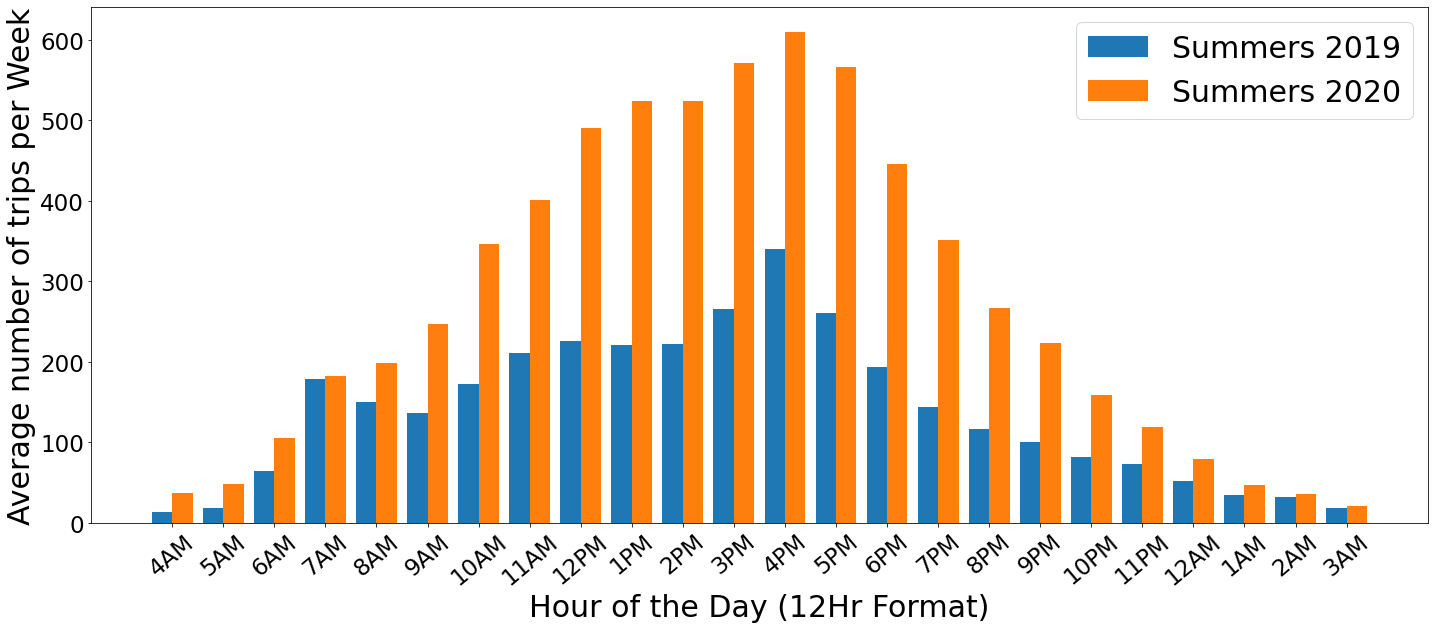

In [15]:
# weekly bike usage during summers of 2019 and 2020
def diff(start, end):
    x = pd.to_datetime(end) - pd.to_datetime(start)
    return int(x / np.timedelta64(1, 'W'))
fig, ax1 = plt.subplots(figsize = (20,9))
plt.bar(np.arange(0,24) - 0.2,np.divide(cycles_2019_summers_hourly, diff(min(cycles_2019_summers['started_at']), max(cycles_2019_summers['started_at']))), width = 0.4)
plt.bar(np.arange(0,24) + 0.2,np.divide(cycles_2020_summers_hourly, diff(min(cycles_2020_summers['started_at']), max(cycles_2020_summers['started_at']))), width = 0.4)
ax1.legend(['Summers 2019', 'Summers 2020'], fontsize = 30)
ax1.set_ylim(0)
labels = ['4AM','5AM','6AM','7AM','8AM','9AM','10AM','11AM','12PM','1PM','2PM','3PM','4PM','5PM','6PM','7PM','8PM','9PM','10PM','11PM','12AM','1AM','2AM','3AM']
plt.xticks(np.arange(0,24), labels=labels, rotation = 40)
plt.tick_params('both', labelsize = 23)
plt.xlabel('Hour of the Day (12Hr Format)',fontsize=30)
plt.ylabel('Average number of trips per Week',fontsize=30)
#plt.title('Weekly bike usage by hour (2019)',fontsize=25)
plt.tight_layout()
plt.savefig('datasets/summers_weekly_bike_usage_by_hour.pdf')

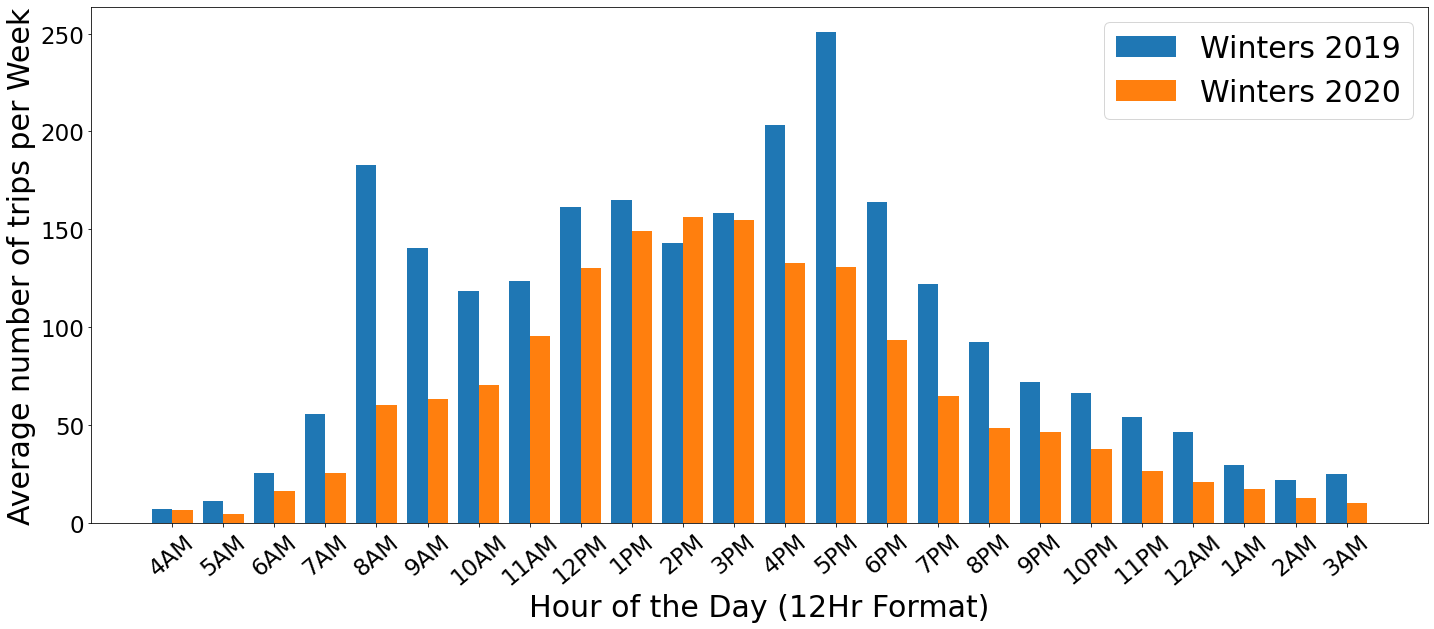

In [16]:
# weekly bike usage during winters of 2019 and 2020 
def diff(start, end):
    x = pd.to_datetime(end) - pd.to_datetime(start)
    return int(x / np.timedelta64(1, 'W'))
fig, ax1 = plt.subplots(figsize = (20,9))
plt.bar(np.arange(0,24) - 0.2,np.divide(cycles_2019_winters_hourly, diff(min(cycles_2019_winters['started_at']), max(cycles_2019_winters['started_at']))), width = 0.4)
plt.bar(np.arange(0,24) + 0.2,np.divide(cycles_2020_winters_hourly, diff(min(cycles_2020_winters['started_at']), max(cycles_2020_winters['started_at']))), width = 0.4)
ax1.legend(['Winters 2019', 'Winters 2020'], fontsize = 30)
ax1.set_ylim(0)
labels = ['4AM','5AM','6AM','7AM','8AM','9AM','10AM','11AM','12PM','1PM','2PM','3PM','4PM','5PM','6PM','7PM','8PM','9PM','10PM','11PM','12AM','1AM','2AM','3AM']
plt.xticks(np.arange(0,24), labels=labels, rotation = 40)
plt.tick_params('both', labelsize = 23)
plt.xlabel('Hour of the Day (12Hr Format)',fontsize=30)
plt.ylabel('Average number of trips per Week',fontsize=30)
#plt.title('Weekly bike usage by hour (2020)',fontsize=25)
plt.tight_layout()
plt.savefig('datasets/winters_weekly_bike_usage_by_hour.pdf')